In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_validate, cross_val_predict, StratifiedKFold
from sklearn.metrics import roc_auc_score, f1_score
from imblearn.combine import SMOTEENN

In [ ]:
# mount drive
from google.colab import drive
drive.mount('/content/drive/')
%cd 'drive/Shareddrives/CSCI 461/processed'
#%ls processed/*

Mounted at /content/drive/
/content/drive/Shareddrives/CSCI 461/processed


# Setting up data

In [ ]:
# Importing the data
data = pd.read_csv("combined_ohe_17.csv") # only 17 yr olds

In [ ]:
# fixing education 

edu_matrix = data[["highedcert_associate degree","highedcert_bachelor degree","highedcert_high school or ged",
                  "highedcert_higher degree","highedcert_none of the above","highedcert_vocational certificate",
                  "highedcert_vocational license"]]
data["edu_categorical"] = edu_matrix.idxmax(axis=1)

educationBinary = \
{   
    "highedcert_associate degree": 1,
    "highedcert_bachelor degree": 1,
    "highedcert_high school or ged": 1,
    "highedcert_higher degree": 1,
    "highedcert_none of the above":0,
    "highedcert_vocational certificate": 1,
    "highedcert_vocational license": 1
}
data['edu_binary'] = data["edu_categorical"].map(educationBinary) 

In [ ]:
target='subabuse_yes'
data.drop(columns=["age"], inplace=True)
data.drop(columns=["recnumbr", "highedcert_associate degree","highedcert_bachelor degree","highedcert_high school or ged",
                  "highedcert_higher degree","highedcert_none of the above","highedcert_vocational certificate",
                  "highedcert_vocational license","edu_categorical", 'currpte_yes', 'currpte_no','currfte_yes', 
                   'currfte_no', 'edu_binary','homeless_no','homeless_yes', 'subabuse_no', 'incarc_no', 'incarc_yes', 'edu_categorical'], axis=1, inplace=True)

In [ ]:
k=5
y = data.loc[:,target]
X = data.loc[:,data.columns != target]
X=X.reset_index(drop=True)
smote_enn = SMOTEENN(random_state=0)
X, y = smote_enn.fit_resample(X, y)

In [ ]:
kfold = StratifiedKFold(n_splits=5,shuffle=True,random_state=11)
#data['target'] IS THE VARIABLE USED FOR STRATIFIED SAMPLING.
splits = kfold.split(X,y)
print(f'PROPORTION OF TARGET IN THE ORIGINAL DATA\n{y.value_counts() / len(y)}\n\n')
for n,(train_index,test_index) in enumerate(splits):
    print(f'SPLIT NO {n+1}\nTRAINING SET SIZE: {np.round(len(train_index) / (len(train_index)+len(test_index)),2)}'+
          f'\tTEST SET SIZE: {np.round(len(test_index) / (len(train_index)+len(test_index)),2)}\nPROPORTION OF TARGET IN THE TRAINING SET\n'+
          f'{y[test_index].value_counts() / len(y[test_index])}\nPROPORTION OF TARGET IN THE TEST SET\n'+
          f'{y[train_index].value_counts() / len(y[train_index])}\n\n')

PROPORTION OF TARGET IN THE ORIGINAL DATA
1    0.618311
0    0.381689
Name: subabuse_yes, dtype: float64


SPLIT NO 1
TRAINING SET SIZE: 0.8	TEST SET SIZE: 0.2
PROPORTION OF TARGET IN THE TRAINING SET
1    0.618246
0    0.381754
Name: subabuse_yes, dtype: float64
PROPORTION OF TARGET IN THE TEST SET
1    0.618328
0    0.381672
Name: subabuse_yes, dtype: float64


SPLIT NO 2
TRAINING SET SIZE: 0.8	TEST SET SIZE: 0.2
PROPORTION OF TARGET IN THE TRAINING SET
1    0.618328
0    0.381672
Name: subabuse_yes, dtype: float64
PROPORTION OF TARGET IN THE TEST SET
1    0.618307
0    0.381693
Name: subabuse_yes, dtype: float64


SPLIT NO 3
TRAINING SET SIZE: 0.8	TEST SET SIZE: 0.2
PROPORTION OF TARGET IN THE TRAINING SET
1    0.618328
0    0.381672
Name: subabuse_yes, dtype: float64
PROPORTION OF TARGET IN THE TEST SET
1    0.618307
0    0.381693
Name: subabuse_yes, dtype: float64


SPLIT NO 4
TRAINING SET SIZE: 0.8	TEST SET SIZE: 0.2
PROPORTION OF TARGET IN THE TRAINING SET
1    0.618328
0    0.3

# Stratified Sampling

In [ ]:
from xgboost import XGBClassifier

# instantiate classifier with default hyperparameters
model=XGBClassifier(class_weight="balanced")
#cm=[0,0,0,0]
auc=[]
f1=[]
y_truth=[]
y_pred=[]
splits = kfold.split(X, y)
for n,(train_index, test_index) in enumerate(splits):
  model.fit(X.iloc[train_index, :-1], y.iloc[train_index])
  pred = model.predict(X.iloc[test_index, :-1])
  f=f1_score(y.iloc[test_index], pred)
  f1.append(f)
  a=roc_auc_score(y.iloc[test_index], pred)
  auc.append(a)
  print("FOLD {} \n AUC {}".format(n,a))
  # yi = my_cm_dec(y.iloc[test_index,], pred)
  # print(yi)
  # cm= [cm[i]+ yi[i] for i in range(len(cm))]
  for i in y[test_index]: y_truth.append(i)
  for i in pred: y_pred.append(i)

"""
print(sum(auc)/5)
print(stdev(auc))
print(sum(f1)/5)
print(stdev(f1))
print(my_cm_dec(y_truth,y_pred))

print("Female by Percenct")
print(my_cm_dec(pd.Series(y_truth).iloc[X.index[X['sex_female'] == True].values], pd.Series(y_pred).iloc[X.index[X['sex_female'] == True].values]))
plt.show()
print("Male by Percenct")
print(my_cm_dec(pd.Series(y_truth).iloc[X.index[X['sex_male'] == True].values], pd.Series(y_pred).iloc[X.index[X['sex_male'] == True].values]))
plt.show()

for i in ['South', 'Midwest', "Northeast", 'West']:
  print("Breakdown by {}".format(i))
  print(my_cm_dec(pd.Series(y_truth)[region.index[region == i]], pd.Series(y_pred)[region.index[region == i]]))
  plt.show()


for i in ['amiakn','asian', 'blkafram', 'hawaiipi', 'white','raceunkn', 'hisorgin']:
  print("Breakdown by {}".format(i))

  print("YES - By percent")
  print(my_cm_dec(pd.Series(y_truth).iloc[X.index[X[i+'_yes'] == True].values], pd.Series(y_pred).iloc[X.index[X[i+'_yes'] == True].values]))
  plt.show()

  print("NO - by percent")
  print(my_cm_dec(pd.Series(y_truth).iloc[X.index[X[i+'_no'] == True].values], pd.Series(y_pred).iloc[X.index[X[i+'_no'] == True].values]))
  plt.show()
"""

In [ ]:
# data with no service columns
data_ns = data.drop(columns=['specedsv_No','specedsv_Yes','ilnasv_No',
 'ilnasv_Yes','acsuppsv_No','acsuppsv_Yes','psedsuppsv_No',
 'psedsuppsv_Yes','careersv_No','careersv_Yes','emplytrsv_No',
 'emplytrsv_Yes','budgetsv_No','budgetsv_Yes','housedsv_No',
 'housedsv_Yes','hlthedsv_No','hlthedsv_Yes','famsuppsv_No',
 'famsuppsv_Yes','mentorsv_No','mentorsv_Yes','silsv_No','silsv_Yes',
 'rmbrdfasv_No','rmbrdfasv_Yes','educfinasv_No','educfinasv_Yes',
 'othrfinasv_No','othrfinasv_Yes'], axis=1)

# X with no service columns
X_ns = X.drop(columns=['specedsv_No','specedsv_Yes','ilnasv_No',
 'ilnasv_Yes','acsuppsv_No','acsuppsv_Yes','psedsuppsv_No',
 'psedsuppsv_Yes','careersv_No','careersv_Yes','emplytrsv_No',
 'emplytrsv_Yes','budgetsv_No','budgetsv_Yes','housedsv_No',
 'housedsv_Yes','hlthedsv_No','hlthedsv_Yes','famsuppsv_No',
 'famsuppsv_Yes','mentorsv_No','mentorsv_Yes','silsv_No','silsv_Yes',
 'rmbrdfasv_No','rmbrdfasv_Yes','educfinasv_No','educfinasv_Yes',
 'othrfinasv_No','othrfinasv_Yes'], axis=1)

In [ ]:
# data with no states
data_ngeo = data.drop(columns = data.filter(regex=("st.*")))

# X with no states
X_ngeo = X.drop(columns = X.filter(regex=("st.*")))


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

def my_cm_dec(y,y_pred):
  cm = confusion_matrix(y,y_pred)
  n=sum(cm.ravel()[:2])
  p=sum(cm.ravel()[2:])
  cm_matrix = pd.DataFrame(data=cm, columns=['Predict Negative:0','Predict Positive:1'], 
                                 index=[ 'Actual Negative:0','Actual Positive:1'])
  cm_matrix = cm_matrix.loc[ ['Actual Positive:1','Actual Negative:0'], [ 'Predict Positive:1', 'Predict Negative:0']]
  cm_matrix.loc['Actual Positive:1', :] = cm_matrix.loc['Actual Positive:1', :] /p
  cm_matrix.loc['Actual Negative:0', :]  = cm_matrix.loc['Actual Negative:0', :] /n
  sns.heatmap(cm_matrix, annot=True, cmap='YlGnBu')
  plt.show()
  return cm.ravel()

def my_scores(mod, X, y,k=5):
  scoring = ['accuracy', 'precision', 'f1', 'recall', 'roc_auc']
  scores = cross_validate(mod, X, y, cv=k,scoring=scoring)
  print("accuracy:",sum(scores["test_accuracy"])/k)
  print("precision:",sum(scores["test_precision"])/k)
  print("auc:",sum(scores["test_roc_auc"])/k)
  print("recall:",sum(scores["test_recall"])/k)
  print("f1:",sum(scores["test_f1"])/k)
  results = [sum(scores["test_accuracy"])/k,
             sum(scores["test_precision"])/k,
             sum(scores["test_roc_auc"])/k,
             sum(scores["test_recall"])/k,
             sum(scores["test_f1"])/k
             ]
  return results

def stdev(test_list):
  mean = sum(test_list) / len(test_list)
  return (sum([((x - mean) ** 2) for x in test_list]) / len(test_list)) ** 0.5

# Random Forest


In [ ]:
pip install -U scikit-learn

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

# SelectFromModel will select those features which importance 
# is greater than the mean importance of all the features by default, but we can 
# alter this threshold if we want.

In [ ]:
"""

sel = SelectFromModel(RandomForestClassifier(n_estimators = 100))
sel.fit(X_train, y_train)
selected_feat= X_train.columns[(sel.get_support())]
len(selected_feat)
pd.series(sel.estimator_,feature_importances_,.ravel()).hist()

"""

In [ ]:
rnd_forest = pd.DataFrame(columns=["Baseline", "Feature_Sel", "Feature_Sel_ns", "Feature_Sel_ngeo"],
                          index = ["accuracy", "precision","auc","recall","f1" ])

accuracy: 0.8892246339807492
precision: 0.8764163747034903
auc: 0.9627330970254302
recall: 0.9541994471613864
f1: 0.912909179035163
TIME: 0.5026739888333338 min


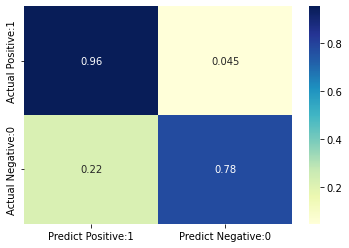

array([11332,  3184,  1057, 22458])

In [ ]:
# BASELINE PERFORMANCE

# instantiate classifier with default hyperparameters
rfc=RandomForestClassifier() 

# make predictions on test set
start = time.perf_counter()
y_pred = cross_val_predict(rfc, X, y, cv=k)
end = time.perf_counter()
rnd_forest["Baseline"] = my_scores(rfc,X,y)
print("TIME:",(end-start)/60,"min")

my_cm_dec(y, y_pred)

In [ ]:
start = time.perf_counter()

# FEATURE SELECTION (all data (includes services, states))

# selecting features
sel = SelectFromModel(RandomForestClassifier(n_estimators = 100))
sel.fit(X, y)
selected_feat= X.columns[(sel.get_support())]
len(selected_feat)
print("SELECTED FEATURES: ")
display(selected_feat)
#pd.Series(sel.estimator_.feature_importances_.ravel()).hist()

# model performance with selected features
X_selected = X.filter(items=selected_feat)
y_pred = cross_val_predict(rfc, X_selected, y, cv=k)
print("Scores:")
rnd_forest["Feature_Sel"] = my_scores(rfc,X,y)
my_cm_dec(y, y_pred)

end = time.perf_counter()
print("TIME:",(end-start)/60,"min")
# should we be cross validating? how? manually?

In [ ]:
start = time.perf_counter()

# FEATURE SELECTION (without services)

# selecting features
sel = SelectFromModel(RandomForestClassifier(n_estimators = 100))
sel.fit(X_ns, y)
selected_feat= X_ns.columns[(sel.get_support())]
len(selected_feat)
print("SELECTED FEATURES: ")
display(selected_feat)
#pd.Series(sel.estimator_.feature_importances_.ravel()).hist()

# model performance with selected features
X_selected = X.filter(items=selected_feat)
y_pred = cross_val_predict(rfc, X_selected, y, cv=k)
print("Scores:")
rnd_forest["Feature_Sel_ns"] = my_scores(rfc,X,y)
my_cm_dec(y, y_pred)

end = time.perf_counter()
print("TIME:",(end-start)/60,"min")

# when we drop services state becomes more prevalent (proxy for services offered)
# look at corr between services offered and states

In [ ]:
start = time.perf_counter()

# FEATURE SELECTION (without states)

# selecting features
sel = SelectFromModel(RandomForestClassifier(n_estimators = 100))
sel.fit(X_ngeo, y)
selected_feat= X_ngeo.columns[(sel.get_support())]
len(selected_feat)
print("SELECTED FEATURES: ")
display(selected_feat)
#pd.Series(sel.estimator_.feature_importances_.ravel()).hist()

# model performance with selected features
X_selected = X.filter(items=selected_feat)
y_pred = cross_val_predict(rfc, X_selected, y, cv=k)
print("Scores:")
rnd_forest["Feature_Sel_ngeo"] = my_scores(rfc,X,y)
my_cm_dec(y, y_pred)

end = time.perf_counter()
print("TIME:",(end-start)/60,"min")

In [ ]:
display(rnd_forest)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

rnd_forest_d = rnd_forest.copy()
rnd_forest_d["idx"] = rnd_forest.index

ax = rnd_forest_d.plot(x="idx", y=rnd_forest.columns, kind="bar", rot=0, ylim=(0.87,0.97), grid=True)

In [ ]:
# Other notes:
  # Maybe should try rand forest reg? so we can get coeffieints for features

# SHAP

In [ ]:
import shap
# compute SHAP values
explainer = shap.Explainer(rfc.predict_proba, X)
rfc.fit(X,y)
shap_values = explainer(X)

Permutation explainer:   1%|          | 267/38031 [01:56<4:58:52,  2.11it/s]


KeyboardInterrupt: ignored

In [ ]:
shap.plots.bar(shap_values)


In [ ]:
38031*.80

30424.800000000003

In [ ]:
import shap

explainer = shap.KernelExplainer(rfc.predict_proba, X[:30424])
shap_values = explainer.shap_values(X[30424:])
shap.force_plot(explainer.expected_value[0], shap_values[0], X)

X does not have valid feature names, but RandomForestClassifier was fitted with feature names


  0%|          | 0/7607 [00:00<?, ?it/s]